In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
from qiskit.visualization.bloch import Bloch
from qiskit.visualization import plot_bloch_vector
from sympy.physics.matrices import msigma
from sympy.physics.quantum.dagger import Dagger
from sympy import Matrix
from sympy import I, N, re, exp, sin, cos, pi, eye
import numpy as np

In [2]:
def to_spherical(vec):
    x = np.real(vec[0])
    y = np.real(vec[1])
    z = np.real(vec[2])
    hxy = np.hypot(x, y)
    r = np.hypot(hxy, z)
    ϕ = np.arctan2(y, x) #az
    θ = np.arctan2(hxy, z) #el
    return [r, ϕ, θ]

def to_cartesian(polar):
    r = polar[0]
    ϕ = polar[1]
    θ = polar[2]

    x = r * np.sin(θ) * np.cos(ϕ)
    y = r * np.sin(θ) * np.sin(ϕ)
    z = r * np.cos(θ)
    return [np.real(x), np.real(y), np.real(z)]

In [3]:
def rn_su2(vec, rot_angle, n):
    spherical_vec = to_spherical(vec)
    ϕ = spherical_vec[1]
    θ = spherical_vec[2]

    # https://www.phys.hawaii.edu/~yepez/Spring2013/lectures/Lecture1_Qubits_Notes.pdf (p. 3)
    sx = msigma(1)
    sy = msigma(2)
    sz = msigma(3)
    M_q = (np.sin(θ)*np.cos(ϕ)*sx + np.sin(θ)*np.sin(ϕ)*sy + np.cos(θ)*sz)
    U_n = eye(2)*cos(rot_angle/2) -I*(n[0]*sx+n[1]*sy+n[2]*sz)*sin(rot_angle/2)
    M_q_rotated = U_n*M_q*Dagger(U_n)
    return M_q_rotated

# taken from Jean-Marie Normand: A Lie Group: Rotations in Quantum Mechanics (p. 67)
# and equivalently https://link.springer.com/content/pdf/bbm%3A978-3-540-29082-7%2F1.pdf
def rn_su2_euler(vec, rx, ry, rz):
    spherical_vec = to_spherical(vec)
    ϕ = spherical_vec[1]
    θ = spherical_vec[2]

    # https://www.phys.hawaii.edu/~yepez/Spring2013/lectures/Lecture1_Qubits_Notes.pdf (p. 3)
    sx = msigma(1)
    sy = msigma(2)
    sz = msigma(3)
    M_q = (np.sin(θ)*np.cos(ϕ)*sx + np.sin(θ)*np.sin(ϕ)*sy + np.cos(θ)*sz)
    U_n = Matrix([[exp(-I*(rx+rz)/2)*cos(ry/2), -exp(-I*(rx-rz)/2)*sin(ry/2)], [exp(I*(rx-rz)/2)*sin(ry/2), exp(I*(rx+rz)/2)*cos(ry/2)]])
    M_q_rotated = U_n*M_q*Dagger(U_n)
    return M_q_rotated

In [4]:
def extract_angles(M_q_rotated):
    cos_θ_rotated = float(N(re(M_q_rotated[0,0])))
    θ_rotated = np.arccos(cos_θ_rotated)
    
    #e^(ix) = cos(x) + i*sin(x), see https://en.wikipedia.org/wiki/Euler%27s_identity
    temp = float(N(re(M_q_rotated[1,0])))
    temp = temp/np.sin(θ_rotated)
    ϕ_rotated = np.arccos(temp)
    return (ϕ_rotated, θ_rotated)

In [5]:
def get_gradient_colors(rgb, n):
    red=rgb[0] 
    yel=rgb[1]
    blu=rgb[2]
    result = [colors.to_hex([red,yel,blu])]
    cr = red/n
    cy = yel/n
    cb = blu/n
    for i in range(n):
        if(red!=0):
            red -= cr 
        if(yel!=0):
            yel -= cy
        if(blu!=0):
            blu -= cb
        result.append(colors.to_hex([red,yel,blu]))
    return result

# SU(2) rotation using axis vector $n=(n_x,n_y,n_z)$

[9.23879533e-01 3.82683432e-01 6.12323400e-17]


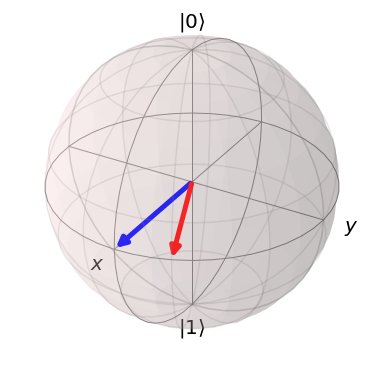

In [6]:
# perform single rotation:
rot_angle = pi/8

# note: SU(2) only covers half of the circle/sphere:
# Guido Fano, S.M. Blinder: Twenty-First Century Quantum Mechanics: Hilbert Space to Quantum Computers (p. 149)

# Magnitude of the vector n must be 1
# see https://www.uni-muenster.de/Physik.TP/archive/fileadmin/lehre/teilchen/ws1011/SO3SU2.pdf
n = [0, 0, 1]

start_vec = [1, 0, 0]

num_iterations = 5
_bloch = Bloch()
_bloch.vector_color = ['blue', 'red']

sv = []
vec = start_vec
sv.append(vec)

M_q_rotated = rn_su2(vec, rot_angle, n)
(ϕ_rotated, θ_rotated) = extract_angles(M_q_rotated)
vec = np.array(to_cartesian([1, ϕ_rotated, θ_rotated]))
print(vec)
sv.append(vec)

_bloch.add_vectors(sv)
_bloch.render()

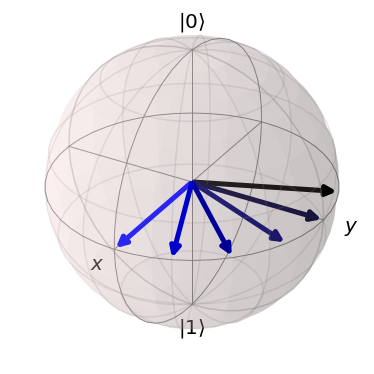

In [7]:
# perform multiple rotation:
rot_angle = pi/8

n = [0, 0, 1]

start_vec = [1, 0, 0]

num_iterations = 5
_bloch = Bloch()
#_bloch.vector_color = ['blue'] * num_iterations
_bloch.vector_color = get_gradient_colors([0, 0, 1], num_iterations)

sv = []
vec = start_vec
sv.append(vec)
for i in range(num_iterations):
    M_q_rotated = rn_su2(vec, rot_angle, n)
    (ϕ_rotated, θ_rotated) = extract_angles(M_q_rotated)
    vec = np.array(to_cartesian([1, ϕ_rotated, θ_rotated]))
    sv.append(vec)

_bloch.add_vectors(sv)
_bloch.render()

# SU(2) rotation using Euler angels $(rot_x,rot_y,rot_z)$

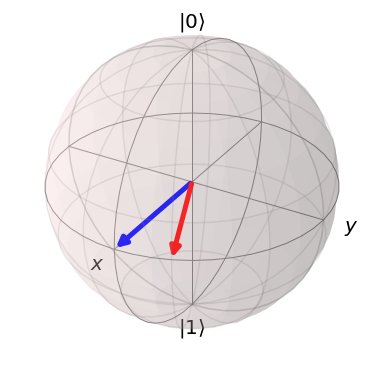

In [8]:
# perform a single rotation:
rot_x = 0
rot_y = 0
rot_z = pi/8

start_vec = [1, 0, 0]

_bloch = Bloch()
_bloch.vector_color = ['blue', 'red']

sv = []
vec = start_vec
sv.append(vec)

M_q_rotated = rn_su2_euler(vec, rot_x, rot_y, rot_z)
(ϕ_rotated, θ_rotated) = extract_angles(M_q_rotated)
vec = np.array(to_cartesian([1, ϕ_rotated, θ_rotated]))
sv.append(vec)

_bloch.add_vectors(sv)
_bloch.render()

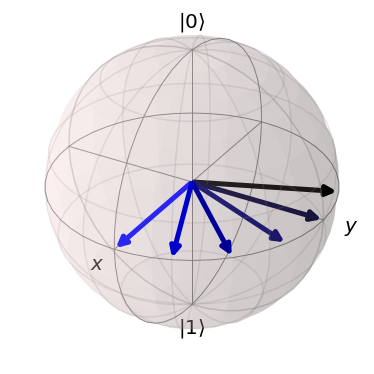

In [9]:
# perform multiple rotations:
rot_x = 0
rot_y = 0
rot_z = pi/8

start_vec = [1, 0, 0]

num_iterations = 5
_bloch = Bloch()
_bloch.vector_color = get_gradient_colors([0, 0, 1], num_iterations)

sv = []
vec = start_vec
sv.append(vec)
for i in range(num_iterations):
    M_q_rotated = rn_su2_euler(vec, rot_x, rot_y, rot_z)
    (ϕ_rotated, θ_rotated) = extract_angles(M_q_rotated)
    vec = np.array(to_cartesian([1, ϕ_rotated, θ_rotated]))
    sv.append(vec)

_bloch.add_vectors(sv)
_bloch.render()

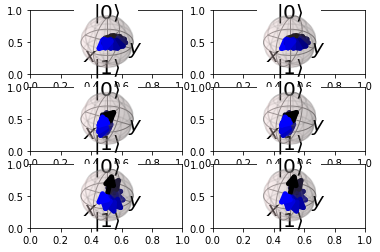

In [33]:
#fig = plt.figure(figsize = [6, 9])
fig, ax = plt.subplots(nrows=3, ncols=2)

# Values are in fractions of figure width and height:
positions = [
    [0, 0],
    [0.5, 0],
    [0, 0.333],
    [0.5, 0.333],
    [0, 0.667],
    [0.5, 0.667],
]

rotations = [[0, 0, pi/8], [0, 0, pi/8], [0, pi/8, 0], [0, pi/8, 0], [0, pi/8, pi/8], [0, pi/8, pi/8]]
start_vec = [1, 0, 0]
num_iterations = 8

for m, rotation in enumerate(rotations):
    #ax = fig.add_axes([positions[m][0], positions[m][1], 0.5, 0.333], axes_class = Axes3D)
    ax = fig.add_subplot(320+(m+1), axes_class = Axes3D)
    rot_x = rotation[0]
    rot_y = rotation[1]
    rot_z = rotation[2]
    _bloch = Bloch(axes=ax)
    _bloch.vector_color = get_gradient_colors([0, 0, 1], num_iterations)
    sv = []
    vec = start_vec
    sv.append(vec)
    for i in range(num_iterations):
        M_q_rotated = rn_su2_euler(vec, rot_x, rot_y, rot_z)
        (ϕ_rotated, θ_rotated) = extract_angles(M_q_rotated)
        vec = np.array(to_cartesian([1, ϕ_rotated, θ_rotated]))
        sv.append(vec)

    _bloch.add_vectors(sv)
    _bloch.render()



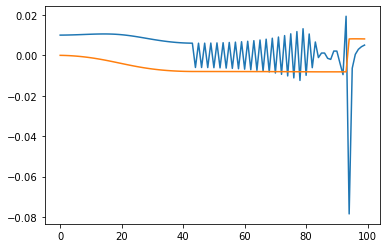

In [14]:
import matplotlib.pyplot as plt

#calculate error propagation

rot_x = pi/100
rot_y = pi/100
rot_z = pi/100
num_iterations = 100

start_vec = [1, 0, 0]
err = 0.01

x = np.arange(0, num_iterations, 1, dtype=int)
ϕ_error_propagation_vec = np.zeros(shape=(num_iterations))
θ_error_propagation_vec = np.zeros(shape=(num_iterations))

vec = start_vec
vec_err = start_vec
sv.append(vec)
for i in range(num_iterations):
    M_q_rotated = rn_su2_euler(vec, rot_x, rot_y, rot_z)
    M_q_rotated_err = rn_su2_euler(vec_err, rot_x+err, rot_y, rot_z) if i==0 else rn_su2_euler(vec_err, rot_x, rot_y, rot_z)
    
    (ϕ_rotated, θ_rotated) = extract_angles(M_q_rotated)
    (ϕ_rotated_err, θ_rotated_err) = extract_angles(M_q_rotated_err)

    θ_error_propagation_vec[i] = θ_rotated_err - θ_rotated
    ϕ_error_propagation_vec[i] = ϕ_rotated_err - ϕ_rotated

    vec = np.array(to_cartesian([1, ϕ_rotated, θ_rotated]))
    vec_err = np.array(to_cartesian([1, ϕ_rotated_err, θ_rotated_err]))

plt.plot(x, ϕ_error_propagation_vec, θ_error_propagation_vec)
plt.show()    

# Backup Stuff:

Use of Operator-class: https://qiskit.org/documentation/tutorials/circuits_advanced/02_operators_overview.html#Operator-Class

In [15]:
from qiskit.quantum_info.operators import Operator
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer
from math import isclose

Aer.backends()
simulator = Aer.get_backend('aer_simulator')
qreg_q = QuantumRegister(1, 'q')
circuit = QuantumCircuit(qreg_q)
clreg = ClassicalRegister(1)

# Matrix taken from
# https://docplayer.org/117986458-Die-symmetriegruppen-so-3-und-su-2.html (p. 11, equation 46)
# https://www.uni-muenster.de/Physik.TP/archive/fileadmin/lehre/teilchen/ws1011/SO3SU2.pdf (p. 8, equation 50)

def rn_su2_qiskit(theta, n):
    if not isclose(np.linalg.norm(n), 1, rel_tol = 0.000001):
        print("Magnitude of n must be 1!")
        return None
    
    n1 = n[0]
    n2 = n[1]
    n3 = n[2]

    return Operator([
        [np.cos(theta/2) - 1j*n3*np.sin(theta/2), -1j*(n1 - 1j*n2)*np.sin(theta/2)],
        [-1j*(n1 + 1j*n2)*np.sin(theta/2), np.cos(theta/2) + 1j*n3*np.sin(theta/2)]
    ], input_dims=(2, 1), output_dims=(2, 1))

# Magnitude of the vector n must be 1
# see https://www.uni-muenster.de/Physik.TP/archive/fileadmin/lehre/teilchen/ws1011/SO3SU2.pdf
n = [0, 0, 1]
#n = [1/np.sqrt(3), 1/np.sqrt(3), 1/np.sqrt(3)]

# Debug: check if the matrix is unitary
mat = np.array(rn_su2_qiskit(np.pi, n))
# Compute A^dagger.A and see if it is identity matrix
mat = np.conj(mat.T).dot(mat)
print(mat)

#usage qiskit version:
#rot_operator = rn_su2(rot_angle, n)
#rot_matrix = np.array(rot_operator)
#M_q_rotated = rot_matrix*M_q*np.matrix(rot_matrix).H

[[1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]
